In [1]:
import pandas as pd
import os
from src.exp_logger import logger  # type: ignore
from src.load_index import setup_system, get_train_splits

import pyterrier as pt  # type: ignore


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


# Reported

In [2]:
path = "../data/results/IRCologne"

In [3]:
results = []

for res in os.listdir(path):
    df = pd.read_csv(os.path.join(path, res), sep="\t", names=["measure", "query", "value"])
    df = df[df["query"]=="all"].set_index("measure")[["value"]].T
    df["run"] = res.split(".")[0]
    df["slice"] = res.split(".")[1]
    results.append(df)

results = pd.concat(results)

In [4]:
results[results["slice"] == "ST"]

measure,map,P_10,recall_1000,ndcg,ndcg_cut_10,run,slice
value,0.1516,0.0965,0.7100,0.2939,0.1808,IRC_RRF(BM25+Bo1-XSqrA_M-PL2),ST
value,0.1900,0.1162,0.6809,0.3256,0.2270,IRC_BM25+monoT5,ST
value,0.1680,0.1036,0.7018,0.3072,0.1982,IRC_d2q+BM25,ST
value,0.1769,0.1078,0.6809,0.3132,0.2121,IRC_BM25+colBERT,ST
value,0.1599,0.0972,0.6774,0.2970,0.1938,IRC_E5_base,ST


# Corrected

In [5]:
path = "../data/results/normalized_IRC"

results = []

for res in os.listdir(path):
    df = pd.read_csv(os.path.join(path, res), sep="\t", names=["measure", "query", "value"])
    df = df[df["query"]=="all"].set_index("measure")[["value"]].T
    df["run"] = res.split(".")[0]
    df["slice"] = res.split(".")[1]
    results.append(df)

results = pd.concat(results)

In [6]:
results[results["slice"] == "WT"][["run", "ndcg", "P_10", "map"]]

measure,run,ndcg,P_10,map
value,normalized_IRC_d2q+BM25,0.4343,0.4323,0.4042
value,normalized_IRC_E5_base,0.4137,0.3972,0.4135
value,normalized_IRC_RRF(BM25+Bo1-XSqrA_M-PL2),0.4379,0.4207,0.4013
value,normalized_IRC_BM25+colBERT,0.4418,0.4351,0.4310
value,normalized_IRC_BM25+monoT5,0.4633,0.4496,0.4511


# Own Results

In [7]:
index_WT, topics_WT, _ = setup_system("WT", train=False)
index_ST, topics_ST, _ = setup_system("ST", train=False)
index_LT, topics_LT, _ = setup_system("LT", train=False)


Loaded index with  1570734 documents.
13:02:44.479 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 3,4 GiB of memory would be required.
Loaded index with  1593376 documents.
13:02:44.723 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 2,3 GiB of memory would be required.
Loaded index with  1081334 documents.


In [8]:
path = "../results/submission"
LT=[pt.BatchRetrieve(index_LT, wmodel="BM25")]
names_LT = ["BM25.WT"]
ST = [pt.BatchRetrieve(index_ST, wmodel="BM25")]
names_ST = ["BM25.ST"]
WT = [pt.BatchRetrieve(index_WT, wmodel="BM25")]
names_WT = ["BM25.LT"]
for name in os.listdir(path):
    if not (name.endswith(".zip") or name.endswith(".meta")):
        if name.endswith(".LT"):
            p = os.path.join(path, name)
            LT.append(pt.io.read_results(os.path.join(path, name)))
            names_LT.append(name)
        elif name.endswith(".ST"):
            ST.append(pt.io.read_results(os.path.join(path, name)))
            names_ST.append(name)
        elif name.endswith(".WT"):
            WT.append(pt.io.read_results(os.path.join(path, name)))
            names_WT.append(name)

In [9]:
qrels_WT = pt.io.read_qrels("../data/longeval-relevance-judgements/heldout-test.txt")
qrels_ST = pt.io.read_qrels("../data/longeval-relevance-judgements/a-short-july.txt")
qrels_LT = pt.io.read_qrels("../data/longeval-relevance-judgements/b-long-september.txt")

In [10]:
results_WT = pt.Experiment(
    WT,
    topics_WT,
    qrels_WT,
    eval_metrics=["ndcg", "P_20", "map", "ndcg_cut_20", "recip_rank", "bpref"],
    names = names_WT,
    round=4,    
    baseline=0,
    correction='bonferroni'

)
print("WT")
results_ST = pt.Experiment(
    ST,
    topics_ST,
    qrels_ST,
    eval_metrics=["ndcg", "P_20", "map", "ndcg_cut_20", "recip_rank", "bpref"],
    names = names_ST,
    round=4,    
    baseline=0,
    correction='bonferroni'
)
print("ST")
results_LT = pt.Experiment(
    LT,
    topics_LT,
    qrels_LT,
    eval_metrics=["ndcg", "P_20", "map", "ndcg_cut_20", "recip_rank", "bpref"],
    names = names_LT,
    round=4,    
    baseline=0,
    correction='bonferroni'
)
print("LT")

WT
ST
LT


In [11]:
results_WT

,name,map,bpref,recip_rank,P_20,ndcg,ndcg_cut_20,map +,map -,map p-value,...,ndcg +,ndcg -,ndcg p-value,ndcg reject,ndcg p-value corrected,ndcg_cut_20 +,ndcg_cut_20 -,ndcg_cut_20 p-value,ndcg_cut_20 reject,ndcg_cut_20 p-value corrected
0,BM25.LT,0.1328,0.2924,0.2479,0.0648,0.2697,0.1945,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,IRC_E5_base.WT,0.1629,0.3270,0.2923,0.0673,0.2891,0.2214,38.0,46.0,0.123987,...,40.0,44.0,0.351482,False,1.000000,33.0,31.0,0.212885,False,1.000000
2,IRC_BM25.WT,0.1328,0.2924,0.2479,0.0648,0.2697,0.1945,0.0,0.0,NaN,...,0.0,0.0,NaN,False,NaN,0.0,0.0,NaN,False,NaN
3,IRC_RRF(BM25+Bo1-XSqrA_M-PL2).WT,0.1355,0.3122,0.2487,0.0658,0.2842,0.1984,47.0,38.0,0.542216,...,49.0,36.0,0.004943,True,0.034599,27.0,19.0,0.516105,False,1.000000
4,IRC_BM25+monoT5.WT,0.1642,0.3093,0.2934,0.0781,0.3034,0.2406,49.0,33.0,0.028947,...,48.0,34.0,0.020446,False,0.143124,40.0,24.0,0.008484,False,0.059385
5,IRC_d2q+BM25.WT,0.1347,0.3109,0.2257,0.0684,0.2746,0.1963,46.0,38.0,0.758876,...,45.0,39.0,0.408708,False,1.000000,27.0,25.0,0.776042,False,1.000000
6,IRC_BM25+colBERT.WT,0.1551,0.3246,0.2572,0.0704,0.2883,0.2189,49.0,34.0,0.201482,...,48.0,35.0,0.278201,False,1.000000,36.0,27.0,0.230508,False,1.000000


In [12]:
results_ST

,name,map,bpref,recip_rank,P_20,ndcg,ndcg_cut_20,map +,map -,map p-value,...,ndcg +,ndcg -,ndcg p-value,ndcg reject,ndcg p-value corrected,ndcg_cut_20 +,ndcg_cut_20 -,ndcg_cut_20 p-value,ndcg_cut_20 reject,ndcg_cut_20 p-value corrected
0,BM25.ST,0.1510,0.3154,0.2567,0.0658,0.2871,0.2127,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,IRC_d2q+BM25.ST,0.1680,0.3353,0.2789,0.0705,0.3072,0.2316,419.0,292.0,1.321947e-07,...,418.0,294.0,1.434699e-11,True,1.004289e-10,273.0,217.0,4.408216e-08,True,3.085751e-07
2,IRC_BM25+monoT5.ST,0.1900,0.3485,0.3271,0.0768,0.3256,0.2602,461.0,250.0,4.500970e-12,...,457.0,254.0,1.776139e-14,True,1.243297e-13,374.0,206.0,1.794930e-14,True,1.256451e-13
3,IRC_RRF(BM25+Bo1-XSqrA_M-PL2).ST,0.1516,0.3264,0.2557,0.0657,0.2939,0.2135,392.0,315.0,7.548445e-01,...,409.0,300.0,1.826293e-03,True,1.278405e-02,245.0,209.0,7.470831e-01,False,1.000000e+00
4,IRC_BM25.ST,0.1510,0.3154,0.2567,0.0658,0.2871,0.2127,0.0,0.0,NaN,...,0.0,0.0,NaN,False,NaN,0.0,0.0,NaN,False,NaN
5,IRC_BM25+colBERT.ST,0.1769,0.3445,0.3100,0.0705,0.3132,0.2419,413.0,296.0,1.958268e-05,...,415.0,296.0,2.904690e-06,True,2.033283e-05,318.0,252.0,2.027037e-05,True,1.418926e-04
6,IRC_E5_base.ST,0.1599,0.3519,0.2915,0.0652,0.2970,0.2227,411.0,356.0,1.347539e-01,...,413.0,354.0,1.012561e-01,False,7.087930e-01,306.0,262.0,1.352639e-01,False,9.468472e-01


In [13]:
results_LT

,name,map,bpref,recip_rank,P_20,ndcg,ndcg_cut_20,map +,map -,map p-value,...,ndcg +,ndcg -,ndcg p-value,ndcg reject,ndcg p-value corrected,ndcg_cut_20 +,ndcg_cut_20 -,ndcg_cut_20 p-value,ndcg_cut_20 reject,ndcg_cut_20 p-value corrected
0,BM25.WT,0.1534,0.3171,0.2645,0.0722,0.2989,0.2168,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,IRC_BM25.LT,0.1534,0.3171,0.2645,0.0722,0.2989,0.2168,0.0,0.0,NaN,...,0.0,0.0,NaN,False,NaN,0.0,0.0,NaN,False,NaN
2,IRC_BM25+colBERT.LT,0.1736,0.3288,0.3188,0.0775,0.3209,0.2439,450.0,337.0,1.891902e-04,...,452.0,336.0,3.100654e-05,True,2.170458e-04,360.0,278.0,5.643166e-05,True,3.950216e-04
3,IRC_d2q+BM25.LT,0.1736,0.3337,0.2937,0.0793,0.3211,0.2397,465.0,328.0,1.903008e-10,...,474.0,321.0,4.664948e-13,True,3.265464e-12,326.0,221.0,2.278088e-10,True,1.594662e-09
4,IRC_BM25+monoT5.LT,0.1895,0.3429,0.3359,0.0856,0.3376,0.2662,513.0,275.0,3.861592e-12,...,500.0,288.0,8.693655e-15,True,6.085559e-14,415.0,234.0,4.422773e-15,True,3.095941e-14
5,IRC_RRF(BM25+Bo1-XSqrA_M-PL2).LT,0.1557,0.3220,0.2716,0.0738,0.3068,0.2202,440.0,347.0,2.756598e-01,...,461.0,327.0,2.311590e-04,True,1.618113e-03,270.0,222.0,1.647482e-01,False,1.000000e+00
6,IRC_E5_base.LT,0.1661,0.3554,0.3050,0.0726,0.3131,0.2325,465.0,378.0,1.521966e-02,...,452.0,391.0,1.245202e-02,False,8.716414e-02,342.0,287.0,1.247800e-02,False,8.734603e-02


In [40]:
results_WT["name"] = results_WT["name"].str.replace(".WT", "")
results_WT["name"] = results_WT["name"].str.replace(".ST", "")
results_ST["name"] = results_ST["name"].str.replace(".ST", "")
results_LT["name"] = results_LT["name"].str.replace(".WT", "")
results_LT["name"] = results_LT["name"].str.replace(".LT", "")

/tmp/ipykernel_23118/2342444376.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  results_WT["name"] = results_WT["name"].str.replace(".WT", "")
/tmp/ipykernel_23118/2342444376.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  results_WT["name"] = results_WT["name"].str.replace(".ST", "")
/tmp/ipykernel_23118/2342444376.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  results_ST["name"] = results_ST["name"].str.replace(".ST", "")
/tmp/ipykernel_23118/2342444376.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  results_LT["name"] = results_LT["name"].str.replace(".WT", "")
/tmp/ipykernel_23118/2342444376.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  results_LT["name"] = results_LT["name"].str.replace(".LT", "")


In [27]:
rall = results_WT.merge(results_ST, left_on="name", right_on="name", suffixes=["_WT", "_ST"]).merge(results_LT, left_on="name", right_on="name", suffixes=["", "_LT"])

In [28]:
rall["ndcg_WT_ST"] = round(rall["ndcg_WT"] - rall["ndcg_ST"],4)
rall["ndcg_WT_LT"] = round(rall["ndcg_WT"] - rall["ndcg"],4)
rall["ndcg_ST_LT"] =round( rall["ndcg_ST"] - rall["ndcg"],4)

rall["P_20_WT_ST"] = round(rall["P_20_WT"] - rall["P_20_ST"],4)
rall["P_20_WT_LT"] = round(rall["P_20_WT"] - rall["P_20"],4)
rall["P_20_ST_LT"] = round(rall["P_20_ST"] - rall["P_20"],4)

rall["map_WT_ST"] = round(rall["map_WT"] - rall["map_ST"],4)
rall["map_WT_LT"] = round(rall["map_WT"] - rall["map"],4)
rall["map_ST_LT"] = round(rall["map_ST"] - rall["map"],4)

rall["ndcg_cut_20_WT_ST"] = round(rall["ndcg_cut_20_WT"] - rall["ndcg_cut_20_ST"],4)
rall["ndcg_cut_20_WT_LT"] = round(rall["ndcg_cut_20_WT"] - rall["ndcg_cut_20"],4)
rall["ndcg_cut_20_ST_LT"] = round(rall["ndcg_cut_20_ST"] - rall["ndcg_cut_20"],4)

rall["recip_rank_WT_ST"] = round(rall["recip_rank_WT"] - rall["recip_rank_ST"],4)
rall["recip_rank_WT_LT"] = round(rall["recip_rank_WT"] - rall["recip_rank"],4)
rall["recip_rank_ST_LT"] = round(rall["recip_rank_ST"] - rall["recip_rank"],4)
rall["bpref_WT_ST"] = round(rall["bpref_WT"] - rall["bpref_ST"],4)
rall["bpref_WT_LT"] = round(rall["bpref_WT"] - rall["bpref"],4)
rall["bpref_ST_LT"] = round(rall["bpref_ST"] - rall["bpref"],4)


In [87]:
rall.to_csv("../data/results/longeval_results.tsv", sep="\t", index=False)

In [29]:
rall.T

,0
name,BM25
map_WT,0.1328
bpref_WT,0.2924
recip_rank_WT,0.2479
P_20_WT,0.0648
...,...
recip_rank_WT_LT,-0.0166
recip_rank_ST_LT,-0.0078
bpref_WT_ST,-0.023
bpref_WT_LT,-0.0247


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

sns.set_style("darkgrid")

In [31]:
results_WT["name"] = results_WT["name"].str.replace(".LT", "").replace(".WT", "")

,name,map,bpref,recip_rank,P_20,ndcg,ndcg_cut_20,map +,map -,map p-value,...,ndcg +,ndcg -,ndcg p-value,ndcg reject,ndcg p-value corrected,ndcg_cut_20 +,ndcg_cut_20 -,ndcg_cut_20 p-value,ndcg_cut_20 reject,ndcg_cut_20 p-value corrected
0,BM25,0.1328,0.2924,0.2479,0.0648,0.2697,0.1945,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,IRC_E5_base.WT,0.1629,0.3270,0.2923,0.0673,0.2891,0.2214,38.0,46.0,0.123987,...,40.0,44.0,0.351482,False,1.000000,33.0,31.0,0.212885,False,1.000000
2,IRC_BM25.WT,0.1328,0.2924,0.2479,0.0648,0.2697,0.1945,0.0,0.0,NaN,...,0.0,0.0,NaN,False,NaN,0.0,0.0,NaN,False,NaN
3,IRC_RRF(BM25+Bo1-XSqrA_M-PL2).WT,0.1355,0.3122,0.2487,0.0658,0.2842,0.1984,47.0,38.0,0.542216,...,49.0,36.0,0.004943,True,0.034599,27.0,19.0,0.516105,False,1.000000
4,IRC_BM25+monoT5.WT,0.1642,0.3093,0.2934,0.0781,0.3034,0.2406,49.0,33.0,0.028947,...,48.0,34.0,0.020446,False,0.143124,40.0,24.0,0.008484,False,0.059385
5,IRC_d2q+BM25.WT,0.1347,0.3109,0.2257,0.0684,0.2746,0.1963,46.0,38.0,0.758876,...,45.0,39.0,0.408708,False,1.000000,27.0,25.0,0.776042,False,1.000000
6,IRC_BM25+colBERT.WT,0.1551,0.3246,0.2572,0.0704,0.2883,0.2189,49.0,34.0,0.201482,...,48.0,35.0,0.278201,False,1.000000,36.0,27.0,0.230508,False,1.000000


In [43]:
slice

,name,map_WT,bpref_WT,recip_rank_WT,P_20_WT,ndcg_WT,ndcg_cut_20_WT,map +_WT,map -_WT,map p-value_WT,...,ndcg +,ndcg -,ndcg p-value,ndcg reject,ndcg p-value corrected,ndcg_cut_20 +,ndcg_cut_20 -,ndcg_cut_20 p-value,ndcg_cut_20 reject,ndcg_cut_20 p-value corrected
0,BM25,0.1328,0.2924,0.2479,0.0648,0.2697,0.1945,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,IRC_E5_base,0.1629,0.3270,0.2923,0.0673,0.2891,0.2214,38.0,46.0,0.123987,...,452.0,391.0,1.245202e-02,False,8.716414e-02,342.0,287.0,1.247800e-02,False,8.734603e-02
2,IRC_BM25,0.1328,0.2924,0.2479,0.0648,0.2697,0.1945,0.0,0.0,NaN,...,0.0,0.0,NaN,False,NaN,0.0,0.0,NaN,False,NaN
3,IRC_RRF(BM25+Bo1-XSqrA_M-PL2),0.1355,0.3122,0.2487,0.0658,0.2842,0.1984,47.0,38.0,0.542216,...,461.0,327.0,2.311590e-04,True,1.618113e-03,270.0,222.0,1.647482e-01,False,1.000000e+00
4,IRC_BM25+monoT5,0.1642,0.3093,0.2934,0.0781,0.3034,0.2406,49.0,33.0,0.028947,...,500.0,288.0,8.693655e-15,True,6.085559e-14,415.0,234.0,4.422773e-15,True,3.095941e-14
5,IRC_d2q+BM25,0.1347,0.3109,0.2257,0.0684,0.2746,0.1963,46.0,38.0,0.758876,...,474.0,321.0,4.664948e-13,True,3.265464e-12,326.0,221.0,2.278088e-10,True,1.594662e-09
6,IRC_BM25+colBERT,0.1551,0.3246,0.2572,0.0704,0.2883,0.2189,49.0,34.0,0.201482,...,452.0,336.0,3.100654e-05,True,2.170458e-04,360.0,278.0,5.643166e-05,True,3.950216e-04


In [44]:
slice = results_WT.merge(results_ST, left_on="name", right_on="name", suffixes=["_WT", "_ST"]).merge(results_LT, left_on="name", right_on="name", suffixes=["", "_LT"])

slice["name"] = ["BM25", "E5", "BM252", "RRF", "monoT5", "d2q", "ColBERT"]

data = slice.set_index("name")[["ndcg_WT", "ndcg_ST", "ndcg"]].rename(columns={"ndcg_WT": "WT", "ndcg_ST": "ST", "ndcg": "LT"}).T


In [46]:
data = data[["BM25", "E5", "RRF", "monoT5", "d2q", "ColBERT"]]

In [ ]:
slice = results_WT.merge(results_ST, left_on="name", right_on="name", suffixes=["_WT", "_ST"]).merge(results_LT, left_on="name", right_on="name", suffixes=["", "_LT"])
slice["name"] = ["E5", "RRF", "monoT5", "d2q", "ColBERT"]

In [50]:
slice = slice[slice["name"] != "BM252"]

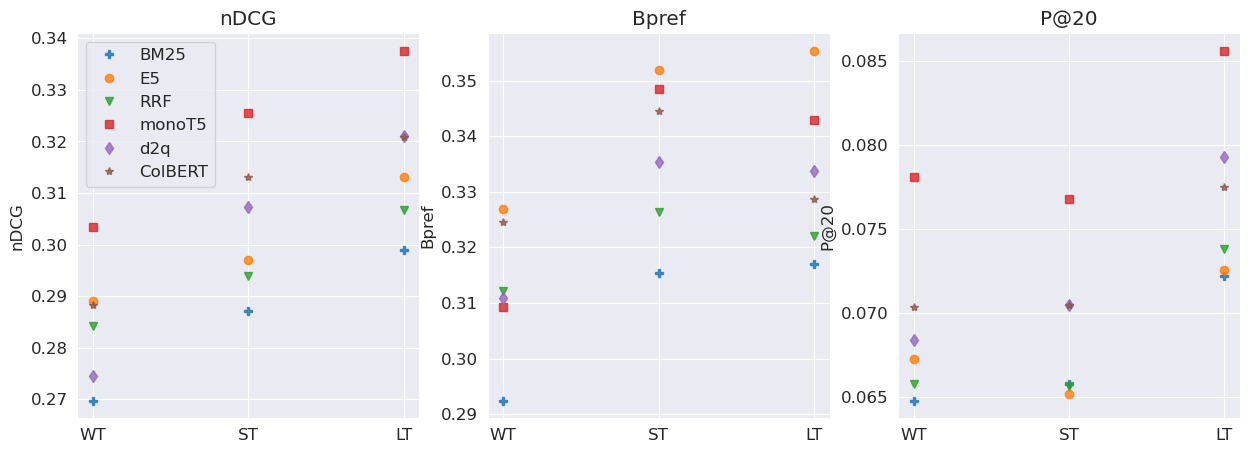

In [60]:
figure, axis = plt.subplots(1, 3, figsize=(15,5))
symbols = ["P","o","v","s", "d", "*"]

ndcg = slice.set_index("name")[["ndcg_WT", "ndcg_ST", "ndcg"]].rename(columns={"ndcg_WT": "WT", "ndcg_ST": "ST", "ndcg": "LT"}).T

bpref = slice.set_index("name")[["bpref_WT", "bpref_ST", "bpref"]].rename(columns={"bpref_WT": "WT", "bpref_ST": "ST", "bpref": "LT"}).T

P_20 = slice.set_index("name")[["P_20_WT", "P_20_ST", "P_20"]].rename(columns={"P_20_WT": "WT", "P_20_ST": "ST", "P_20": "LT"}).T

# recip_rank = slice.set_index("name")[["recip_rank_WT", "recip_rank_ST", "recip_rank"]].rename(columns={"recip_rank_WT": "WT", "recip_rank_ST": "ST", "recip_rank": "LT"}).T

for i, sym in enumerate(symbols):
    axis[0].plot(ndcg.index, ndcg[ndcg.columns[i]], sym, alpha=0.8)
    axis[1].plot(bpref.index, bpref[bpref.columns[i]], sym, alpha=0.8)
    axis[2].plot(P_20.index, P_20[P_20.columns[i]], sym, alpha=0.8)

axis[0].legend(P_20.columns, loc='upper left')
axis[0].set_ylabel("nDCG")
axis[0].set_title("nDCG")
axis[1].set_ylabel("Bpref")
axis[1].set_title("Bpref")
axis[2].set_ylabel("P@20")
axis[2].set_title("P@20")
figure.savefig("../results-scatter.png", dpi=300, bbox_inches='tight')

In [8]:
results_WT_pt = pt.Experiment(
    WT,
    topics_WT,
    qrels_WT,
    eval_metrics=["ndcg", "P_20", "map", "ndcg_cut_20", "recip_rank", "bpref"],
    names = names_WT,
    round=4,
    perquery=True
)

results_ST_pt = pt.Experiment(
    ST,
    topics_ST,
    qrels_ST,
    eval_metrics=["ndcg", "P_20", "map", "ndcg_cut_20", "recip_rank", "bpref"],
    names = names_ST,
    round=4,
    perquery=True
)
results_LT_pt = pt.Experiment(
    LT,
    topics_LT,
    qrels_LT,
    eval_metrics=["ndcg", "P_20", "map", "ndcg_cut_20", "recip_rank", "bpref"],
    names = names_LT,
    round=4,
    perquery=True
)

In [31]:
for system in results_WT_pt["name"].unique():
    WT_sys = results_WT_pt[results_WT_pt["name"].str.startswith(system)]
    WT_sys = results_WT_pt[results_WT_pt["name"].str.startswith(system)]

In [33]:
for system in results_WT_pt["name"].unique():
    WT_sys = results_WT_pt[results_WT_pt["name"].str.startswith(system[:-3])]
    ST_sys = results_ST_pt[results_ST_pt["name"].str.startswith(system[:-3])]

    WT_sys = WT_sys[WT_sys["measure"] == "ndcg"]
    ST_sys = ST_sys[ST_sys["measure"] == "ndcg"]
    # LT_sys = results_LT_pt[results_LT_pt["name"].str.startswith(system[:-3])]
    

    WT_sys = pd.pivot_table(WT_sys, values = 'value', index=['qid'], columns = 'name').reset_index()
    ST_sys = pd.pivot_table(ST_sys, values = 'value', index=['qid'], columns = 'name').reset_index()

    merged = WT_sys.merge(ST_sys, left_on="qid", right_on="qid", suffixes=["_WT", "_ST"])
    merged["delta"] = merged[merged.columns[1]] - merged[merged.columns[2]]




In [ ]:
pivot_results = pd.pivot_table(results_WT_pt, values = 'value', index=['qid'], columns = 'name').reset_index()
pivot_results["delta"] = pivot_results["IRCologne-RRF(BBXP).WT"] - pivot_results["IRCologne-BM25.WT"]
ax = pivot_results['delta'].sort_values(ascending=False).plot(figsize=(12,4), kind='bar')
ax.set_xlabel("Topics")
ax.set_ylabel('$\Delta$ nDCG')
plt.title("Reciprocal Rank Fusion vs. BM25")
plt.show()